
# Create a natural language classifier with Bert and Tensorflow

High performance transformer models such as BERT and GPT-3 transform a wide range of previously menial and language-based tasks into a few clicks job, saving a lot of time.

In most industries, the latest wave of language optimization is just beginning - taking its first steps. But these plants are widespread and grow quickly.

Much of this adoption is due to the incredibly low barrier to entry. If you know the basics of TensorFlow or PyTorch and take some time to familiarize yourself with the Transformers library, you're already halfway there.

With the Transformers library, it only takes three lines of code to initialize a cutting-edge ML model - a model built from billions of research dollars spent by Google, Facebook, and OpenAI.

This article will walk you through the steps to create a classification model that harnesses the power of transformers, using Google's BERT. 
- Finding Models
- Initializing
- Bert Inputs and Outputs
Classification
- The Data
- Tokenization
- Data Prep
- Train-Validation Split
- Model Definition
- Train
Results
# Transformateurs
## Find models

We will be using BERT, possibly the most well-known transformer architecture.

To understand what we need to use BERT, we head to the HuggingFace template page (HuggingFace built the Transformer framework).

Once there, we will find both bert-base-cased and bert-base-uncased on the first page. cased means that the pattern distinguishes between uppercase and lowercase, whereas this uncase does not.
## Initialization

If we click on the model we find more specific details. On this page we can see the model initialization code. Because we are using TensorFlow, our code will use TFAutoTokenizer and TFAutoModel instead of AutoTokenizer and AutoModel, respectively:


In [ ]:
import pandas as pd
from transformers import TFBertModel
seed_value = 42
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
np.set_printoptions(precision=2)
import tensorflow as tf
tf.random.set_seed(seed_value)
#import tensorflow_addons as tfa
import tensorflow.keras
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
print(tf.test.gpu_device_name())
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth


In [ ]:
from transformers import AutoTokenizer,TFAutoModel
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
bert = TFAutoModel.from_pretrained("bert-base-cased")

When inserting textual data into our model, there are a few things to consider. First, we need to use tokenizer.encode_plus (...) to convert our text to input ID and attention mask tensors (we'll talk about that later).

BERT expects these two tensors as inputs. One mapped to "input_ids" and another to "attention_mask".

At the other end of the spectrum, BERT generates two default tensors (more are available). These are "last_hidden_state" and "pooler_output".

The output of the pooler is simply the last hidden state, processed slightly further by a linear layer and a Tanh activation function - this also reduces its dimensionality from 3D (last hidden state) to 2D (output of pooler).

Later we will consume the last hidden state tensor and remove the output from the pooler.

# Classification
## Data

CommonLit Readability Prize . We can download and extract it programmatically, like this:

In [ ]:
# Import the datasets
train_raw= pd.read_csv('../input/commonlitreadabilityprize/train.csv')
test_raw = pd.read_csv('../input/commonlitreadabilityprize/test.csv')

# Simple EDA 

In [ ]:
train_raw.head()

In [ ]:
# Perform EDA on the train
train_raw.shape ,train_raw.dtypes

# Preparation and Feature Extraction 

# Tokenization
We have our text data in the textcolumn, which we now need to tokenize. We will use the BERT tokenizer, because we will use a BERT transformer later.

# Train Data
## feature Extraction X :

In [ ]:
from transformers import AutoTokenizer

SEQ_LEN = 128  # we will cut/pad our sequences to a length of 128 tokens

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

# initialize two arrays for input tensors
Xids = np.zeros((len(train_raw), SEQ_LEN))
Xmask = np.zeros((len(train_raw), SEQ_LEN))

for i, sentence in enumerate(train_raw['excerpt']):
    Xids[i, :], Xmask[i, :] = tokenize(sentence)
    if i % 10000 == 0:
        print(i)  # do this so we can see some progress

In [ ]:
Xids

In [ ]:
Xmask

Here we first import the transformers library and initialize a tokenizer for the bert-base-casedmodel used. A list of models can be found here. We then define a tokenize function which manages the tokenization.

We use the encode_plus method of our BERT tokenizer to convert a sentence into input_ids and attention_masktensors.

Entry IDs are a list of integers uniquely related to a specific word.

The attention mask is a list of 1s and 0s that match the IDs in the entry ID array - BERT reads this and only applies attention to IDs that match a mask value of attention of 1. This allows us to avoid drawing attention to the filler tokens.

Our encode_plus arguments are:

    Our award. It is simply a string representing a text.
    The max_length of our encoded outputs. We use a value of 32 which means that each output tensor has a length of 32.
    We cut the sequences that are more than 32 tokens in length with truncation = True.
    For sequences shorter than 32 tokens, we pad them with zeros up to a length of 32 using padding = 'max_length'.
    BERT uses several special tokens, to mark the start / end of sequences, for padding, unknown words and mask words. We add those using add_special_tokens = True.
    BERT also takes two inputs, the input_idset attention_mask. We extract the attention mask with return_attention_mask = True.
    By default the tokenizer will return a token type ID tensor - which we don't need, so we use return_token_type_ids = False.
    Finally, we use TensorFlow, so we return the TensorFlow tensors using return_tensors = 'tf'. If you are using PyTorch, use return_tensors = 'pt'.

# Lables preparation



In [ ]:
labels = train_raw['target'].values  # take sentiment column in df as array

In [ ]:
labels

This whole process can take some time. I like to save the encoded tables so that we can recover them in case of problems or for future tests.

with open('xids.npy', 'wb') as f:
    np.save(f, Xids)
with open('xmask.npy', 'wb') as f:
    np.save(f, Xmask)
with open('labels.npy', 'wb') as f:
    np.save(f, labels)

Now that we have all the arrays encoded, we load them into a TensorFlow dataset object. Using the dataset, we easily restructure, mix and group the data.

In [ ]:
import tensorflow as tf

BATCH_SIZE = 32  # we will use batches of 32

# load arrays into tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

# create a mapping function that we use to restructure our dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# using map method to apply map_func to dataset
dataset = dataset.map(map_func)

# shuffle data and batch it
dataset = dataset.shuffle(100000).batch(BATCH_SIZE)

In [ ]:
type(dataset)

# Train validation separation

The last step before training our model is to divide our dataset into training, validation, and (optionally) testing sets. We will stick to a simple 90–10 train-validation separation here.

In [ ]:
# get the length of the batched dataset
DS_LEN = len([0 for batch in dataset])
SPLIT = 0.9  # 90-10 split

train = dataset.take(round(DS_LEN*SPLIT))  # get first 90% of batches
val = dataset.skip(round(DS_LEN*SPLIT))  # skip first 90% and keep final 10%

del dataset  # optionally, delete dataset to free up disk-space

# Definition of the model

Our data is now ready and we can define our model architecture. We'll use BERT, followed by an LSTM layer and a few simple NN layers. These last layers after BERT are our classifier.

Our classifier uses the hidden state tensors output from BERT - using them to predict our target.
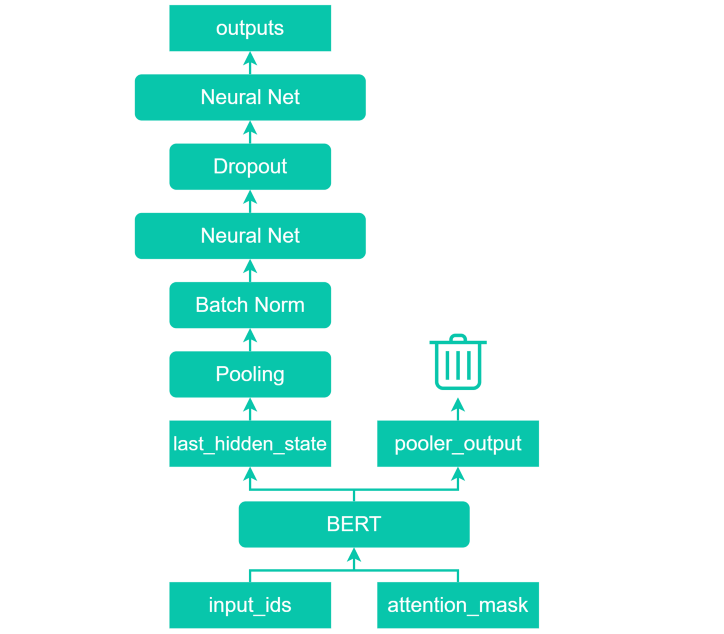

In [ ]:
from transformers import AutoModel

# initialize cased BERT model
bert = TFAutoModel.from_pretrained('bert-base-cased')

input_ids = tf.keras.layers.Input(shape=(128,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(128,), name='attention_mask', dtype='int32')

# we consume the last_hidden_state tensor from bert (discarding pooled_outputs)
embeddings = bert(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.LSTM(64)(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
y = tf.keras.layers.Dense(1, name='outputs')(X)

# define input and output layers of our model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze the BERT layer - otherwise we will be training 100M+ parameters...
model.layers[2].trainable = False

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76, )

# Coaching

We can now train our model. First, we configure our optimizer (Adam), our loss function, and our precision metric. Then we compile the model and practice!

In [ ]:
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
optimizer = tf.keras.optimizers.Adam(0.01)
#loss = tf.keras.losses.CategoricalCrossentropy()  # categorical = one-hot
rmse = RootMeanSquaredError()
best_weights_file = "./weights.h5"
batch_size = 16
max_epochs= 1000
m_ckpt = ModelCheckpoint(best_weights_file, monitor='val_auc', mode='max', verbose=2,
                             save_weights_only=True, save_best_only=True)
es = EarlyStopping(monitor='loss',min_delta=0.0000000000000000001, patience=10)

model.compile(optimizer=optimizer, loss='mse', metrics=[rmse])

In [ ]:
# fit model using our gpu
with tf.device('/gpu:0'):
    history = model.fit(
            train,
            validation_data=val,
            epochs=max_epochs,
            batch_size=batch_size,
            callbacks=[m_ckpt,es],
            verbose=2
        )

# Evaluate :

In [ ]:
loss, root_mean_squared_error = model.evaluate( val, verbose=0)
print('root_mean_squared_error_model: %f' % (accuracy *100))
print('loss_model: %f' % (loss *100))

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
def plot_history(history):
    acc = history.history['root_mean_squared_error']
    val_acc = history.history['val_root_mean_squared_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training root_mean_squared_error')
    plt.plot(x, val_acc, 'r', label='Validation root_mean_squared_error')
    plt.title('Training and validation root_mean_squared_error')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

In [ ]:
#model = load_model()
#tokenizer= DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
predictions = model.predict(val)

# Plot prediction 

def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()


# Predict Unseen Data :

In [ ]:
test_raw = pd.read_csv('../input/commonlitreadabilityprize/test.csv')
test_raw.head()

In [ ]:
SEQ_LEN = 128 # we will cut/pad our sequences to a length of 128 tokens

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

# initialize two arrays for input tensors
Xids = np.zeros((len(test_raw), SEQ_LEN))
Xmask = np.zeros((len(test_raw), SEQ_LEN))

for i, sentence in enumerate(test_raw['excerpt']):
    Xids[i, :], Xmask[i, :] = tokenize(sentence)
    if i % 10000 == 0:
        print(i)  # do this so we can see some progress
BATCH_SIZE = 1  # we will use batches of 1

# load arrays into tensorflow dataset
test = tf.data.Dataset.from_tensor_slices((Xids, Xmask, [0]*len(test_raw)))

# create a mapping function that we use to restructure our dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# using map method to apply map_func to dataset
Unseen_test_prep = test.map(map_func)

# shuffle data and batch it
Unseen_test_prep = Unseen_test_prep.shuffle(100000).batch(BATCH_SIZE)   
preds = model.predict(Unseen_test_prep)     

In [ ]:
preds

In [ ]:
test_raw['id'].values


# Prepare Submission File

We make submissions in CSV files. Your submissions usually have two columns: an ID column and a prediction column. The ID field comes from the test data (keeping whatever name the ID field had in that data, which for the housing data is the string 'Id'). The prediction column will use the name of the target field.

We will create a DataFrame with this data, and then use the dataframe's to_csv method to write our submission file. Explicitly include the argument index=False to prevent pandas from adding another column in our csv file.


In [ ]:
my_submission = pd.DataFrame({'id': test_raw.id, 'target': preds.ravel()})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)



In [ ]:
my_submission